# PIPELINE

Voici le Pipeline reprenant les 3 livrables de notre projet. Les explications seront brèves et le notebook sera court puisque toutes les explications, prétraitement et entrainement de nos modèles auront déjà été faites lors des livrables précédents. Concrètement nous allons faire passer nos images de test dans notre denoiser, puis le classeur binaire et enfin le captionneur.
Ce notebook chargera nos différents modèles pré-entrainés, les datas et les traitera de façon subséquente.

Normalement vous n'aurez aucun chemin d'accès à modifier.

In [39]:
import tensorflow as tf   
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import pad_sequences, load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input, InceptionV3
import numpy as np
import random
import glob
import os
import pickle
from PIL import Image
import cv2
from keras import backend as K
from keras.models import Model

## Vérifier tensorflow

On vérifie si le GPU est disponible. Normalement vous en avez pas besoin et les opérations se feront automatiquement sur le CPU. Si ça ne marche pas, installez Tensorflow 2.10 avec accélération GPU

In [ ]:
print(tf.__version__)
print('GPU Available: ', tf.config.list_physical_devices('GPU'))

Vous pouvez changer le Batch_size (ça ne changera rien aux résultats néanmoins) par contre, ne touchez pas à l'image size. Nos modèles n'accepte que du 304

In [2]:
BATCH_SIZE = 64
IMG_SIZE = (304, 304)

In [3]:
def save_image(image, directory, class_name, index):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    class_directory = os.path.join(directory, class_name)
    if not os.path.exists(class_directory):
        os.makedirs(class_directory)
    filename = os.path.join(class_directory, f"image_{index}.png")
    image = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to 8-bit pixel values
    image.save(filename)

Ici on charge le dataset et on le normalize. Changez le chemin d'accès en fonction de là où vous avez vos photos.

Note : avec dataset_from_directory, il faut que vos photos soient dans une dossier réprésentant vos classes.

Dossier principal
    - Classe_1
        Vos photos
    - Classe_2
        Vos photos

Si vous n'avez pas de classe spécifique, vous pouvez juste faire un dossier contenant un autre sous dossier (peu un importe le nom) contenant vos photos. Le chemin seras donc juste le nom du dossier principal tandis que le sous dossier ne servira que de label à vos images.

In [34]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

test_dataset = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\2077900\Projet\data\D_S',
    seed = 48,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Found 56 files belonging to 2 classes.


In [5]:
class_names = ['Not Photos', 'Photo']

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

On importe le modèle pré-entrainer du denoiser. (Modifier le chemins d'accès si besoin)

In [6]:
model = tf.keras.models.load_model("models/ae_model.model")

In [7]:
model.encoder.summary()
model.decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 152, 152, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 256)      0         
 2D)                                                             
                                                           

2/2 [==============================] - 74s 29s/step


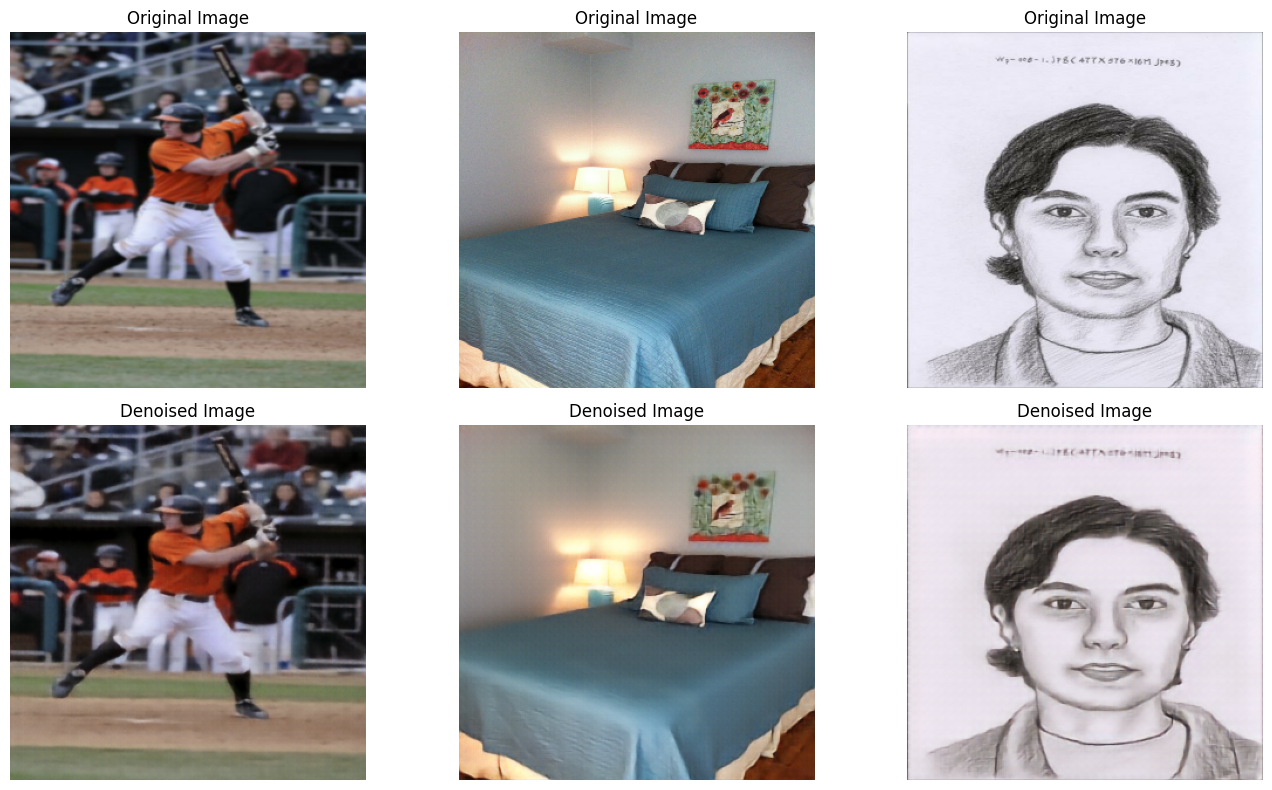

In [8]:
n = 3  # Reduce the number of images if they're too large
plt.figure(figsize=(14, 8))  # Increase figure size (width, height) in inches

for image_batch, _ in test_dataset.take(1):
    denoised_images = model.predict(image_batch)
    break

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((image_batch[i] * 255).numpy().astype("uint8"))  # Reverse the normalization step
    plt.title("Original Image")
    plt.axis("off")

    # Denoised
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow((denoised_images[i] * 255).astype("uint8"))  # Reverse the normalization step, removed `.numpy()`
    plt.title("Denoised Image")
    plt.axis("off")

plt.tight_layout()  # This will help to make sure everything fits
plt.show()

Ici on sauvegarde les datas dénoisé. (Modifier le chemins d'accès si besoin)

In [9]:
save_dir = r'C:\Users\2077900\Projet\data\Nouveau Dataset\Dataset_Pipeline_Denoised'

class_names = ['0', '1']

for batch, (images, labels) in enumerate(test_dataset):
    denoised_images = model.predict(images)
    for i, (image, label) in enumerate(zip(denoised_images, labels.numpy())):
        class_name = str(label)
        index = batch * BATCH_SIZE + i
        save_image(image, save_dir, class_name, index)

2/2 [==============================] - 1s 1s/step


On recharge les données. (Modifier le chemins d'accès si besoin)

In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\2077900\Projet\data\Nouveau Dataset\Dataset_Pipeline_Denoised',
    seed = 48,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Found 56 files belonging to 1 classes.


On importe le classeur binaire (Modifier le chemins d'accès si besoin)

In [11]:
model = tf.keras.models.load_model("models/Meileur.model")

2/2 [==============================] - 2s 802ms/step


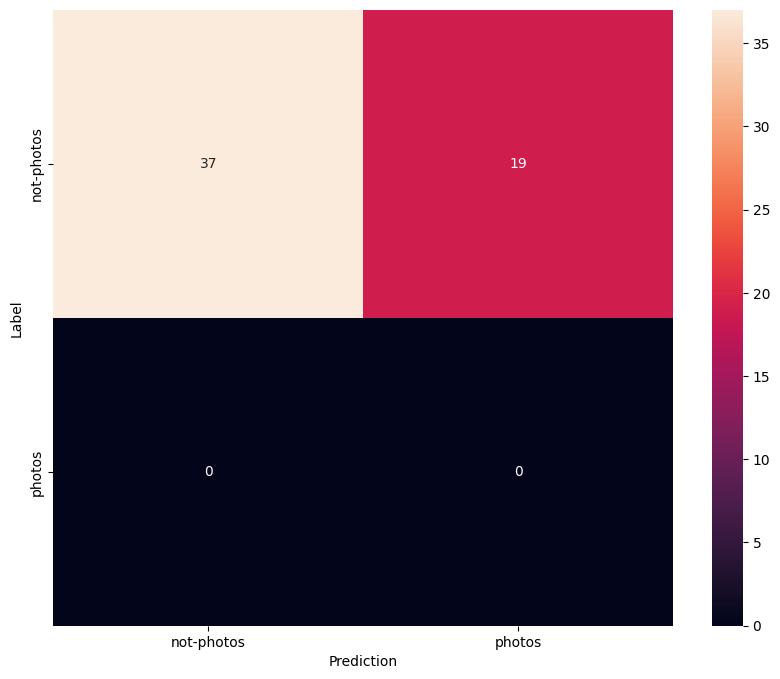

Total Accuracy: 66.07%
Photos Prediction Accuracy: nan%
Non-Photos Prediction Accuracy: 66.07%


C:\Users\2077900\AppData\Local\Temp\ipykernel_14672\2872966709.py:33: RuntimeWarning: invalid value encountered in scalar divide
  photo_prediction_accuracy = TP / (TP + FN)


In [12]:
true_labels = []
predictions = []

for img, label in test_dataset:
    pred = model.predict(img)
    pred = tf.round(pred).numpy().flatten()  # Round the predictions to get binary output
    predictions.extend(pred)
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_labels, predictions)

class_names = ["not-photos", "photos"]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

TN = confusion_mtx[0,0].numpy()
FP = confusion_mtx[0,1].numpy()
FN = confusion_mtx[1,0].numpy()
TP = confusion_mtx[1,1].numpy()

# Calculating accuracies
total_accuracy = (TP + TN) / (TP + TN + FP + FN)
photo_prediction_accuracy = TP / (TP + FN)
non_photos_prediction_accuracy = TN / (TN + FP)

print(f"Total Accuracy: {total_accuracy*100:.2f}%")
print(f"Photos Prediction Accuracy: {photo_prediction_accuracy*100:.2f}%")
print(f"Non-Photos Prediction Accuracy: {non_photos_prediction_accuracy*100:.2f}%")

Un exemple de prédiction (ne pas prendre en compte le true si vos données n'ont pas été étiquettées)

In [13]:
def plot_images_with_predictions(dataset, model, class_names, num_rows=5, num_cols=5):
    plt.figure(figsize=(15, 15))
    num_images = num_rows*num_cols
    for i, (img, label) in enumerate(dataset.take(num_images)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Rescale the image pixel values from 0-1 to 0-255
        rescaled_img = (img[0].numpy() * 255).astype("uint8")

        plt.imshow(rescaled_img, cmap=plt.cm.binary)  # Now the image tensor is in the correct scale

        # Make a prediction
        pred = model.predict(img)
        pred_class = class_names[int(tf.round(pred).numpy().flatten()[0])]
        true_class = class_names[label[0]]

        # Set the title of each image to the prediction made by the model
        color = "green" if pred_class == true_class else "red"
        plt.xlabel(f"Pred: {pred_class}\nTrue: {true_class}", color=color)
    
    plt.tight_layout()
    plt.show()

# Call the function with your test dataset
plot_images_with_predictions(test_dataset, model, class_names, num_rows=5, num_cols=5)

2/2 [==============================] - 0s 281ms/step


On sauvegarde uniquement les images prédites comme photos. (Modifier le chemins d'accès si besoin)

In [40]:
save_dir = r'C:\Users\2077900\Projet\data\Nouveau Dataset\Dataset_Pipeline_Photos'
index = 0

for images, _ in test_dataset:
    predictions = model.predict(images)
    for i, pred in enumerate(predictions):
        # Assuming that you have binary classification, thus 0.5 threshold
        if pred >= 0.5:
            save_image(images[i].numpy(), save_dir, "photos", index)
            index += 1

ValueError: in user code:

    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\2077900\AppData\Local\miniconda3\envs\Projet\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 304, 304, 3) dtype=float32>]


On va charger les données classés comme photos. (Modifier le chemins d'accès si besoin)

In [41]:
def get_image_paths(directory):
    image_extensions = ['.jpeg', '.jpg', '.png', '.gif', '.tiff', '.bmp', '.webp']
    image_paths = []

    for subdir, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(subdir, file))

    return image_paths

directory_path = "./data/Nouveau Dataset/Dataset_Pipeline_Photos/photos/"
all_image_paths = get_image_paths(directory_path)

On importe InceptionV3

In [42]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

Ici, on va charger les dictionnaires contenant nos tokens (nos mots). On en a besoin afin de labeliser nos images (Modifier le chemins d'accès si besoin).

In [43]:
embeddings_index = {} 
f = open(os.path.join('./data/Glove/', 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_dim = 200
embedding_matrix = np.zeros((1660, embedding_dim))

wordtoix = {}
with open('./data/Vocabulaire/wordtoix.pkl', 'rb') as fichier:
    wordtoix = pickle.load(fichier)

ixtoword = {}
with open('./data/Vocabulaire/ixtoword.pkl', 'rb') as fichier:
    ixtoword = pickle.load(fichier)

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

Ici on encode nos images afin de les faire passer dans notre réseau

In [45]:
encoded_images = dict()

for img in all_image_paths:
    encoded_images[img[len(directory_path):]] = encode(img)    

1/1 [==============================] - 0s 10ms/step


Pour finir, on importe le RNN, c'est à dire le modèle qui va labeliser nos images en fonction des features trouvées par InceptionV3. (Modifier le chemins d'accès si besoin)

In [46]:
model = tf.keras.models.load_model("models/Captioning_test.h5")

On utilise Beam search afin de légender nos photos (voir Livrable 3 pour plus d'explication) puis on affiche nos images avec leurs labels.

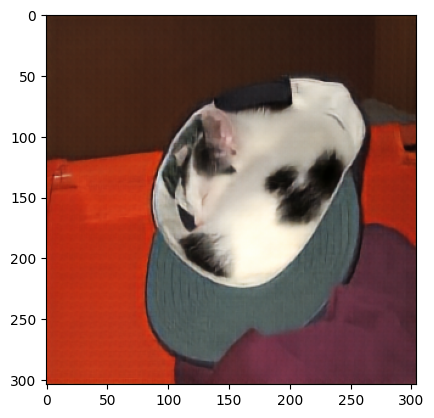

Beam Search, K = 3: a small white dog is running on the street with a blue object in its mouth
Beam Search, K = 5: a white dog and a brown and white dog playing with a purple toy
Beam Search, K = 7: a small white dog stands on his hind legs in front of two cats
Beam Search, K = 10: there is a brown and white dog looking at the camera in front of a set of


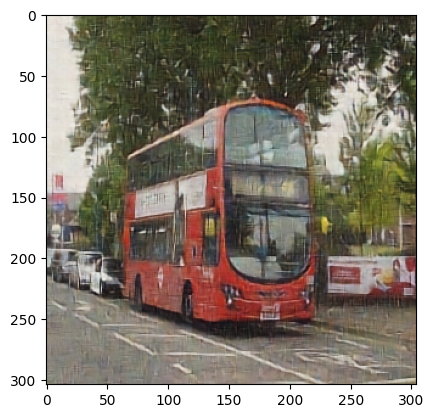

Beam Search, K = 3: a group of people are standing in front of a blue and yellow bus
Beam Search, K = 5: a group of people are standing in front of a blue and yellow bus
Beam Search, K = 7: a group of people are standing in front of a blue and yellow bus
Beam Search, K = 10: a group of people are standing in front of a blue and yellow bus


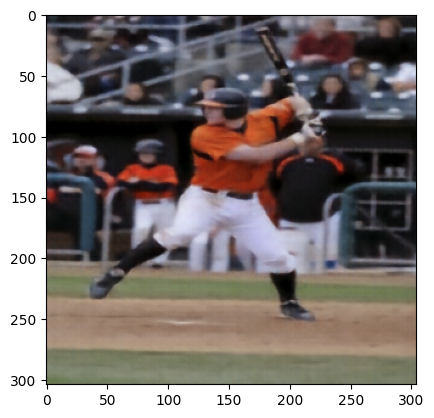

Beam Search, K = 3: a man in a sports uniform is playing a baseball game for a baseball game
Beam Search, K = 5: a man in a sports uniform playing a baseball game
Beam Search, K = 7: a man in a sports uniform playing a baseball game at a baseball game
Beam Search, K = 10: a little boy in a baseball game at a baseball game


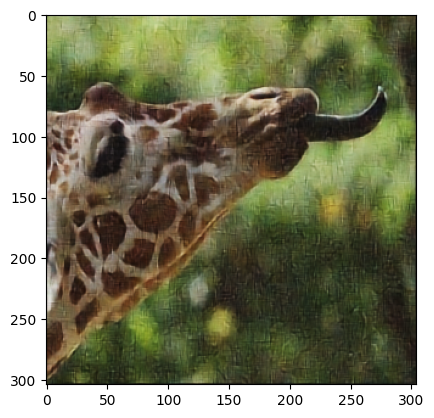

Beam Search, K = 3: a man and a woman are standing in front of a blue and yellow flowers
Beam Search, K = 5: a man with a shaved head stands next to a woman in a blue shirt
Beam Search, K = 7: a man with a shaved head stands next to a brown and white dog on a leash
Beam Search, K = 10: a man with a shaved head stands next to a brown and white dog on a leash


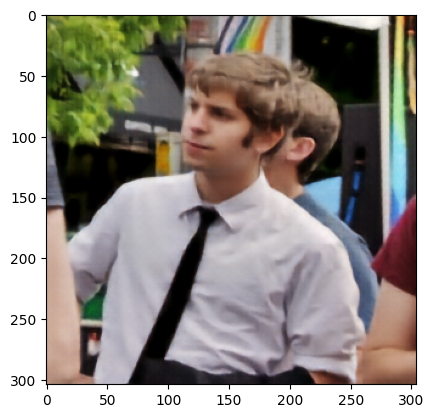

Beam Search, K = 3: the man is standing next to a desk
Beam Search, K = 5: the man is standing next to a table full of soda
Beam Search, K = 7: the man is standing next to a desk in front of a full of
Beam Search, K = 10: the man is standing next to a table full of soda


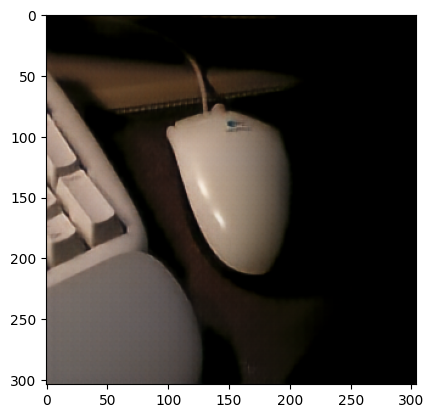

Beam Search, K = 3: a small black and white dog licking its head
Beam Search, K = 5: a black and white dog playing with a red toy
Beam Search, K = 7: a black and white dog playing with a purple toy
Beam Search, K = 10: a black and white dog playing with a pine cone


Beam Search, K = 3: a baseball pitcher is following the ball
Beam Search, K = 5: a baseball pitcher crouches to catch the ball
Beam Search, K = 7: a baseball pitcher crouches to catch the ball
Beam Search, K = 10: a boy in a baseball game


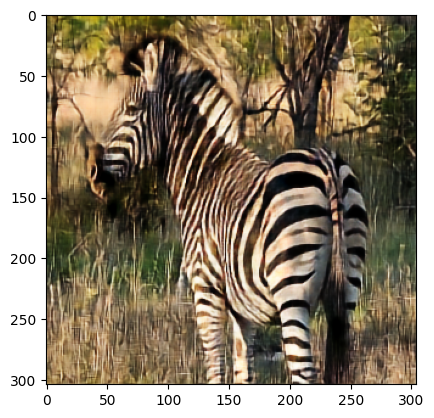

Beam Search, K = 3: a young boy with a blue shirt is standing in front of a white and blue truck
Beam Search, K = 5: a man and a woman are standing in front of a blue and yellow car
Beam Search, K = 7: a man and a woman are standing in front of a blue and yellow car
Beam Search, K = 10: there is a brown and white dog playing with a red toy


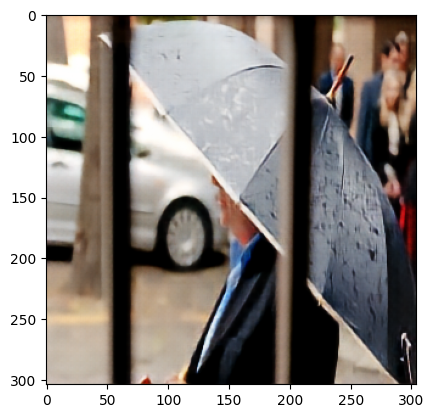

Beam Search, K = 3: a man is wearing a blue shirt and black shoes
Beam Search, K = 5: a man on a skateboard is performing a trick on a half pipe
Beam Search, K = 7: a man on a skateboard is performing a trick in the air
Beam Search, K = 10: there is a man in a blue shirt and a woman in a blue shirt are standing in front of a white building


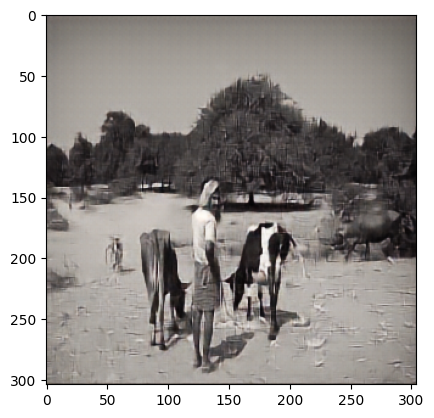

Beam Search, K = 3: a group of people sitting on the edge of a busy street
Beam Search, K = 5: a group of people sitting on the edge of a busy street
Beam Search, K = 7: a group of people sitting on the edge of a busy street
Beam Search, K = 10: a group of people sitting on the edge of a busy street


Beam Search, K = 3: a small brown and white dog jumping over a hurdle
Beam Search, K = 5: a brown and white dog is jumping over a hurdle
Beam Search, K = 7: a brown and white dog jumping over a red and white hurdle
Beam Search, K = 10: a brown and white dog plays with a toy in front of a white house


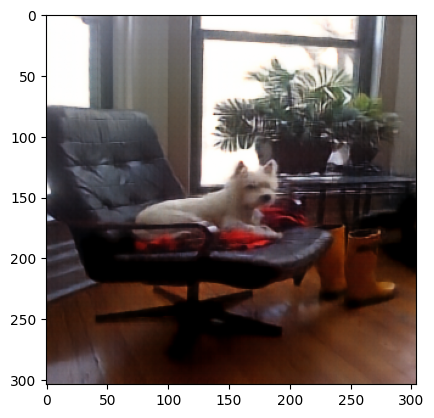

Beam Search, K = 3: a white dog and a tricolored dog look at each other
Beam Search, K = 5: a white dog and a tricolored dog look at each other
Beam Search, K = 7: a black and white dog plays with a purple toy
Beam Search, K = 10: there is a brown and white dog laying on its hind legs next to a counter


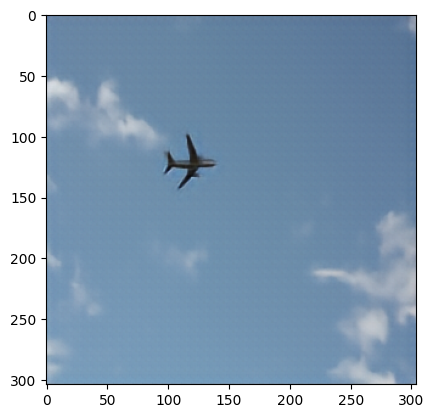

Beam Search, K = 3: a white bird is flying through the air to catch a toy
Beam Search, K = 5: there is a white bird with brown markings flying flying in the grass
Beam Search, K = 7: there is a white bird with brown markings flying flying in the grass
Beam Search, K = 10: there is a brown and white bird playing with a small plane


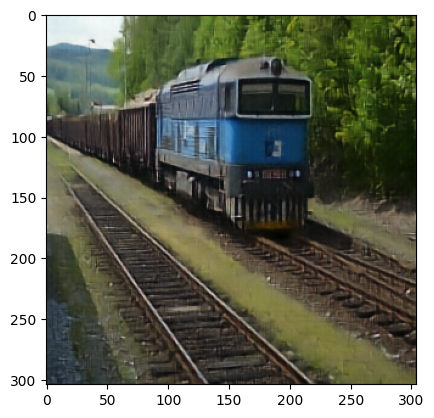

Beam Search, K = 3: a man in a blue shirt is standing next to a red and yellow building
Beam Search, K = 5: a brown and white dog licks its nose
Beam Search, K = 7: there is a brown and white dog playing with a yellow toy
Beam Search, K = 10: there is a brown and white dog playing with a yellow toy


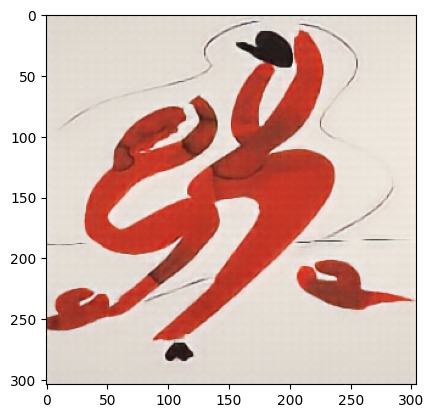

Beam Search, K = 3: a man in a blue shirt is standing next to a man who is standing next to a woman who is standing next to a brick wall
Beam Search, K = 5: a man with a shaved head stands next to a man who is standing next to a woman who is standing next to a brick wall
Beam Search, K = 7: a man with a shaved head stands next to a man who is standing next to a man who is standing next to a brick wall surrounded by


In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < 38:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=38, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption
    
for i in range(18):
    pic = list(encoded_images.keys())[i]
    image = encoded_images[pic].reshape((1,2048))
    x=plt.imread(directory_path+pic)
    plt.imshow(x)
    plt.show()
    print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
    print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
    print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
    print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))